# **ALFA dataset Anomaly Binary Classificataion using Mcfly module reference, torch Windows 40**

**Anomaly Classification using CNN**

In [1]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 64.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 7.6 MB/s eta 0:00:00


In [2]:
!pip install mcfly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.5 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


## **Import Dependencies**

In [14]:
import os
import sys
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import Counter
from sktime.datatypes import convert_to
from timeit import default_timer as timer
from sktime.datasets import load_from_tsfile
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from mcfly.modelgen import generate_models
from mcfly.find_architecture import find_best_architecture
from mcfly.find_architecture import train_models_on_samples
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')
np.random.seed(42)

**Load Dataset**

In [4]:
# Load Seq data**
X = np.load('/kaggle/input/alfa-dataset-seq-2/ALFA_dataset_seq_class_2/alfa_dataset_sequence_X.npy')
y = np.load('/kaggle/input/alfa-dataset-seq-2/ALFA_dataset_seq_class_2/alfa_dataset_sequence_y.npy')
print(X.shape)
print(y.shape)

(2792, 40, 17)
(2792,)


In [5]:
X

array([[[-2.99999982e-01, -5.02687256e+02, -3.81405678e+01, ...,
          0.00000000e+00,  0.00000000e+00, -1.41265686e+02],
        [-5.00000000e-01, -4.64151947e+02, -3.39043388e+01, ...,
         -4.02072650e-01,  2.74586200e-01, -1.32508072e+02],
        [-6.59999967e-01, -4.55761536e+02, -2.98145447e+01, ...,
         -7.35498750e-01,  5.29559100e-01, -1.32508072e+02],
        ...,
        [ 4.19999987e-01, -2.06515320e+02,  1.19351387e+01, ...,
         -9.80665000e-02,  4.11879300e-01,  5.87478771e+01],
        [ 1.19999997e-01, -1.71426575e+02,  1.07295952e+01, ...,
         -9.80665000e-02,  4.11879300e-01,  6.25918961e+01],
        [-2.99999982e-01, -1.28605652e+02,  9.14689636e+00, ...,
         -9.80665000e-02,  4.11879300e-01,  6.25918961e+01]],

       [[-1.14999998e+00, -4.22000488e+02, -1.81564999e+01, ...,
         -8.72791850e-01, -3.04006150e-01, -1.08404129e+02],
        [-1.32999992e+00, -4.31838043e+02, -1.45433483e+01, ...,
         -5.39365750e-01,  4.60912550e

**Z-score Normalize**

In [6]:
mean = np.mean(X, axis=(0, 1), keepdims=True)
std = np.std(X, axis=(0, 1), keepdims=True)

# Z-score normalize the array
X = (X - mean) / std

**Encoding**

In [7]:
ohe = OneHotEncoder()

y = ohe.fit_transform(y.reshape(-1, 1)).toarray()
y.shape

(2792, 2)

## **Train-test-Split**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, random_state=42,
                                                    shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.20, random_state=42,
                                                  shuffle=True, stratify=y_train)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1786, 40, 17) (447, 40, 17) (559, 40, 17)
(1786, 2) (447, 2) (559, 2)


**Incorporate class weights to handle class imbalance** 

In [9]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(y, axis=1)),
    y = np.argmax(y, axis=1)
)

class_weights = dict(zip(np.unique(np.argmax(y, axis=1)), class_weights))
class_weights

{0: 0.5377503852080123, 1: 7.122448979591836}

## **Define CNN Model** 

In [10]:
%%time

file_name = f"model-comparison-20220808.json"
output_file = os.path.join("/kaggle/working/", file_name)
model_path = "/kaggle/working/"

metric_key = "pr_auc"
metric = AUC(curve="PR", name=metric_key )

# metric_key = "accuracy"
# metric = "accuracy"

models = generate_models(
    X_train.shape,
    y_train.shape[1],
    number_of_models=3,
    model_types=['CNN'],
    metrics=[metric]
)

history, val_metrics, val_losses = train_models_on_samples(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models=models,
    nr_epochs=30,
    verbose=True,
    model_path=model_path,
    outputfile=output_file,
    subset_size=int(X_train.shape[0] / 2),
    class_weight=class_weights
)

Generated models will be trained on subset of the data (subset size: 893).
Training model 0 CNN
Epoch 1/30


I0000 00:00:1722174514.970609     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 [==============================] - 13s 40ms/step - loss: 0.8926 - pr_auc: 0.5095 - val_loss: 0.8560 - val_pr_auc: 0.3609
Epoch 2/30
45/45 [==============================] - 1s 15ms/step - loss: 0.6668 - pr_auc: 0.5922 - val_loss: 0.8623 - val_pr_auc: 0.4095
Epoch 3/30
45/45 [==============================] - 1s 15ms/step - loss: 0.5577 - pr_auc: 0.6435 - val_loss: 0.8121 - val_pr_auc: 0.5594
Epoch 4/30
45/45 [==============================] - 1s 16ms/step - loss: 0.4744 - pr_auc: 0.7221 - val_loss: 0.8636 - val_pr_auc: 0.5322
Epoch 5/30
45/45 [==============================] - 1s 14ms/step - loss: 0.4713 - pr_auc: 0.7425 - val_loss: 1.0210 - val_pr_auc: 0.5215
Epoch 6/30
45/45 [==============================] - 1s 17ms/step - loss: 0.4108 - pr_auc: 0.8193 - val_loss: 0.9668 - val_pr_auc: 0.5918
Epoch 6: early stopping
Training model 1 CNN
Epoch 1/30
45/45 [==============================] - 8s 29ms/step - loss: 1.0567 - pr_auc: 0.5271 - val_loss: 1.0600 - val_pr_auc: 0.3323
Epoch 

**Find best model**

In [11]:
best_model_index = np.argmax(val_metrics[metric_key])
best_model, best_params, best_model_type = models[best_model_index]

print(best_model_index)
print("Best model type:", best_model_type)

2
Best model type: CNN


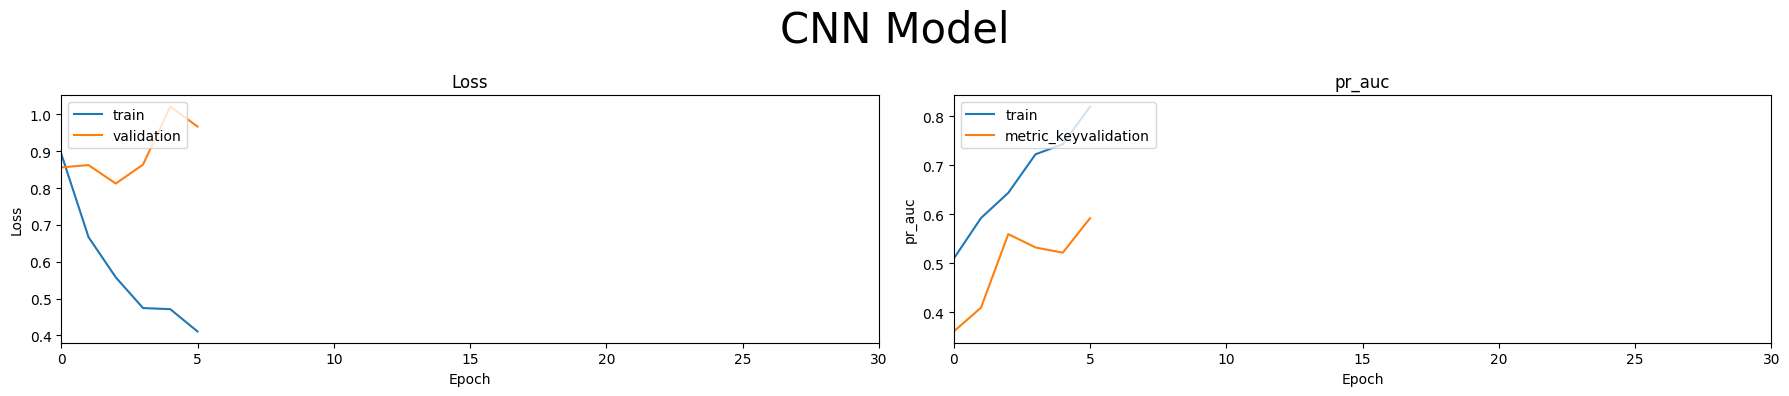

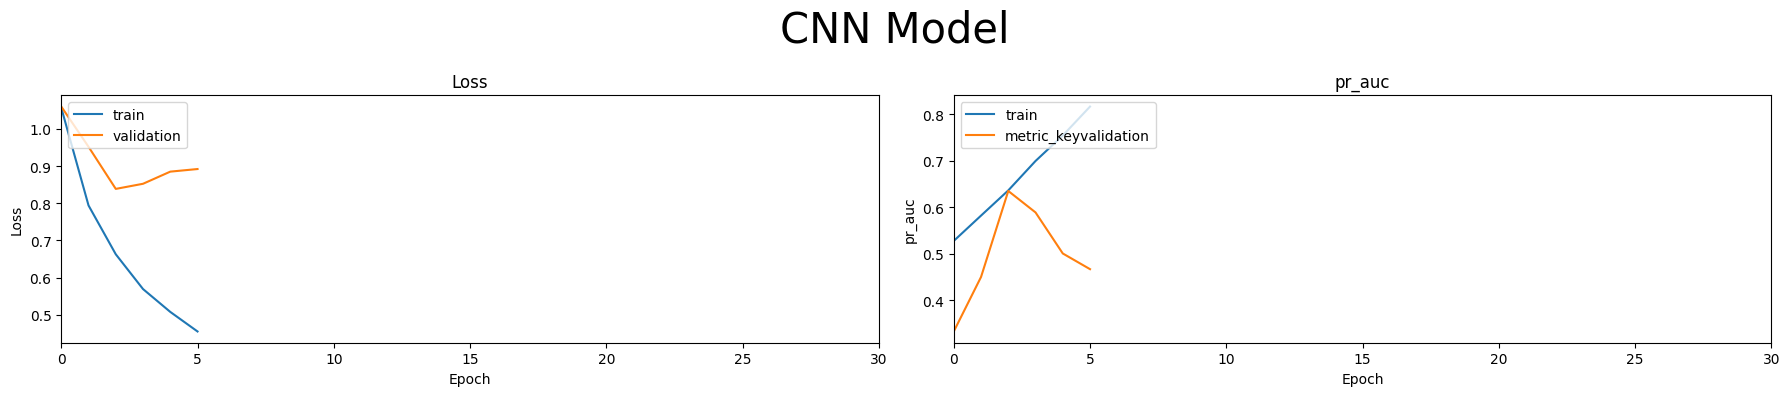

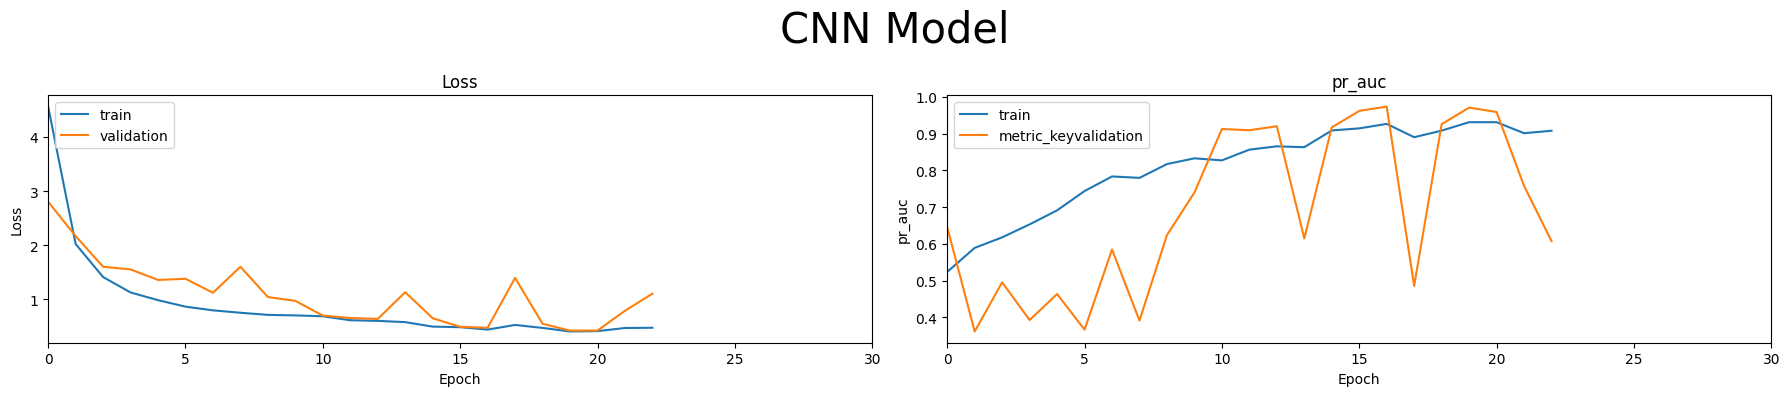

In [12]:
# performance comparison

model_types = list(map(lambda m: m[2],models))

for i in range(len(model_types)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 4))

    fig.suptitle(f"{model_types[i]} Model", fontsize=30)

    ax1.plot(history[i].history['loss'])
    ax1.plot(history[i].history['val_loss'])
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_xlim([0, 30])
    ax1.legend(['train', 'validation'], loc='upper left')

    ax2.plot(history[i].history[metric_key])
    ax2.plot(history[i].history[f'val_{metric_key}'])
    ax2.set_title(metric_key)
    ax2.set_ylabel(metric_key)
    ax2.set_xlabel('Epoch')
    ax2.set_xlim([0, 30])
    ax2.legend(['train', 'metric_keyvalidation'], loc='upper left')

    plt.tight_layout()
    plt.show()

## **Model Training**

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_path = 'best_model.h5'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


**Train**

In [17]:
%%time

history = best_model.fit(
    X_train,
    y_train,
    epochs=70,
    callbacks=[early_stopping, checkpoint_callback],
    validation_data=(X_val, y_val),
)

Epoch 1/70
54/56 [===========================>..] - ETA: 0s - loss: 0.1803 - pr_auc: 0.9916
Epoch 1: val_loss did not improve from 0.19701
56/56 [==============================] - 0s 7ms/step - loss: 0.1782 - pr_auc: 0.9919 - val_loss: 0.2040 - val_pr_auc: 0.9936
Epoch 2/70
54/56 [===========================>..] - ETA: 0s - loss: 0.1624 - pr_auc: 0.9952
Epoch 2: val_loss did not improve from 0.19701
56/56 [==============================] - 0s 6ms/step - loss: 0.1634 - pr_auc: 0.9952 - val_loss: 0.2237 - val_pr_auc: 0.9746
Epoch 3/70
53/56 [===========================>..] - ETA: 0s - loss: 0.1580 - pr_auc: 0.9954
Epoch 3: val_loss did not improve from 0.19701
56/56 [==============================] - 0s 6ms/step - loss: 0.1588 - pr_auc: 0.9949 - val_loss: 0.2327 - val_pr_auc: 0.9655
Epoch 4/70
56/56 [==============================] - ETA: 0s - loss: 0.1682 - pr_auc: 0.9869
Epoch 4: val_loss did not improve from 0.19701
56/56 [==============================] - 0s 6ms/step - loss: 0.1682 -

## **Prediction**

In [20]:
# load the best checkpoint model
from keras.models import load_model
best_model = load_model('/kaggle/working/best_model.h5')
#model.summary()

In [21]:
import time

t = time.time()
y_pred = best_model.predict(X_test, batch_size=1)
print(time.time() - t)

559/559 [==============================] - 1s 2ms/step
1.2661685943603516


In [50]:
import time

t = time.time()
y_pred = model.predict(X_test, batch_size=1)
print(time.time() - t)

559/559 [==============================] - 3s 4ms/step

3.2594869136810303


## **Performance Metrics**

In [51]:
print(f"Classification report fot the {best_model_type} model:\n")
print(
    classification_report(
        np.argmax(y_test, axis=1),
        np.argmax(y_pred, axis=1),
        digits=4
    )
)

Classification report fot the InceptionTime model:



              precision    recall  f1-score   support



           0     0.9980    0.9788    0.9883       520

           1     0.7755    0.9744    0.8636        39



    accuracy                         0.9785       559

   macro avg     0.8868    0.9766    0.9260       559

weighted avg     0.9825    0.9785    0.9796       559




**Confusion Metrics**

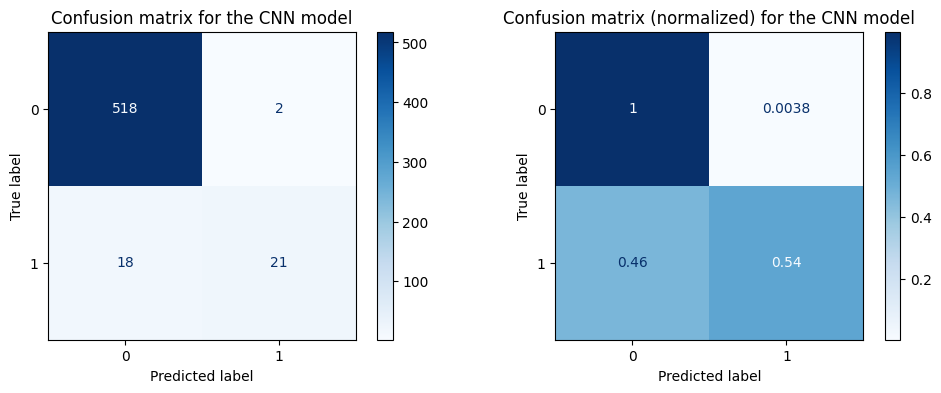

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize=None,
    cmap="Blues",
    ax=ax1
)

ax1.set_title(f"Confusion matrix for the {best_model_type} model")

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize="true",
    cmap="Blues",
    ax=ax2
)

ax2.set_title(f"Confusion matrix (normalized) for the {best_model_type} model")

plt.show()

--THE END--